In [95]:
import sys


import mlflow
from seisbench_training.utils.model_utils import SeisBenchLit
import pandas as pd
import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pathlib import Path
import torch

from sklearn.metrics import (
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    matthews_corrcoef,
    mean_absolute_error,
)


In [96]:
def get_eval_augmentations():
    return [
        sbg.SteeredWindow(windowlen=3001, strategy="pad"),
        sbg.ChangeDtype(np.float32),
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
        
    ]


In [97]:
def load_best_model_mlflow(experiment_name: str, best_model_path: str) -> SeisBenchLit:
    # Get the experiment by name
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experiment '{experiment_name}' not found.")

    # Search for runs in the experiment
    runs: pd.DataFrame = mlflow.search_runs(experiment.experiment_id)
    if runs.empty:
        raise ValueError(f"No runs found for experiment '{experiment_name}'.")

    runs_df_filtered = runs[runs["status"] == "FINISHED"][
        [
            col
            for col in runs.columns
            if col.startswith("params.") or col.startswith("metrics.")
        ]
    ].dropna()

    runs_df_indices = runs_df_filtered.sort_values(
        "metrics.val_loss",
        ascending=False,
    ).index
    runs_df = runs.loc[runs_df_indices, :]

    best_run_id = runs_df["run_id"].tolist()[0]
    best_run_df = runs_df[runs_df["run_id"] == best_run_id]

    artifact_dir = best_run_df["artifact_uri"].iloc[0]

    return SeisBenchLit.load_from_checkpoint(artifact_dir + best_model_path)


In [98]:
model_gaussian_scratch = load_best_model_mlflow(
    "full_training_gaussian",
    "/best_model_gaussian/best_model_gaussian.ckpt",
)

model_gaussian_transfer = load_best_model_mlflow(
    "transfer_learning",
    "/epoch=97-step=9212/epoch=97-step=9212.ckpt",
)

labels = pd.read_csv("output/generated_labels.csv")
dataset = sbd.bohemia.BohemiaSaxony(
    sampling_rate=100, cache="full", component_order="ZNE"
)

In [99]:
waveform_data = torch.load("/home/khuzaima/project/thesis_seismology/notebooks/example_waveform.pt", map_location=torch.device("cpu"))

In [100]:
results_scratch_model = pd.read_parquet("data/predictions_scratch_model.parquet")
results_transfer_model = pd.read_parquet("data/predictions_transfer_model.parquet")

In [101]:
test_data = dataset.get_split("test")
test_data = test_data.get_waveforms(10)
test_gen = sbg.GenericGenerator(test_data)
test_gen.add_augmentations(get_eval_augmentations())
test_loader = torch.utils.data.DataLoader(
        test_gen,
        batch_size=32,
        shuffle=True,
        num_workers=0,
    )

In [102]:
def predict(model: pl.LightningModule, set_name: list, dataset: sbd.BenchmarkDataset) -> pd.DataFrame:
    for set in set_name:
        split = dataset.get_split(set)
        if split is None:
            raise ValueError(f"Dataset does not have a split named '{set}'.")
        split.preload_waveforms(pbar=True)
        labels_subset = labels[
            labels["trace_split"] == set
        ].copy()  # avoid modifying original df
        generator = sbg.SteeredGenerator(split, labels_subset)
        generator.add_augmentations(get_eval_augmentations())

        loader = torch.utils.data.DataLoader(
            generator,
            batch_size=1024,
            shuffle=False,
            num_workers=16,
        )
        trainer = pl.Trainer()

        predictions = trainer.predict(model, loader)
        merged_predictions = []
        for i, _ in enumerate(predictions[0]):
            merged_predictions.append(torch.cat([x[i] for x in predictions]))

        merged_predictions = [x.cpu().numpy() for x in merged_predictions]
        labels_subset["score_detection"] = merged_predictions[0]
        labels_subset["score_p_or_s"] = merged_predictions[1]
        labels_subset["p_sample_pred"] = (
            merged_predictions[2] + labels_subset["start_sample"]
        )
        labels_subset["s_sample_pred"] = (
            merged_predictions[3] + labels_subset["start_sample"]
        )

    return labels_subset

In [103]:
set_name = ["test"]

In [104]:

results_scratch_model = predict(model_gaussian_scratch, set_name, dataset)

Preloading waveforms: 100%|██████████| 23718/23718 [00:09<00:00, 2603.14it/s]
/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/khuzaima/miniforge3/envs/seisbench/lib/python3 ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
results_transfer_model = predict(model_gaussian_transfer, set_name, dataset)

Preloading waveforms: 100%|██████████| 23718/23718 [00:15<00:00, 1576.44it/s]
/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/khuzaima/miniforge3/envs/seisbench/lib/python3 ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results_scratch_model.to_parquet("data/predictions_scratch_model.parquet")
results_transfer_model.to_parquet("data/predictions_transfer_model.parquet")

In [ ]:
results_scratch_model["phase_label_bin"] = results_scratch_model["phase_label"] == "P"
results_transfer_model["phase_label_bin"] = results_transfer_model["phase_label"] == "P"

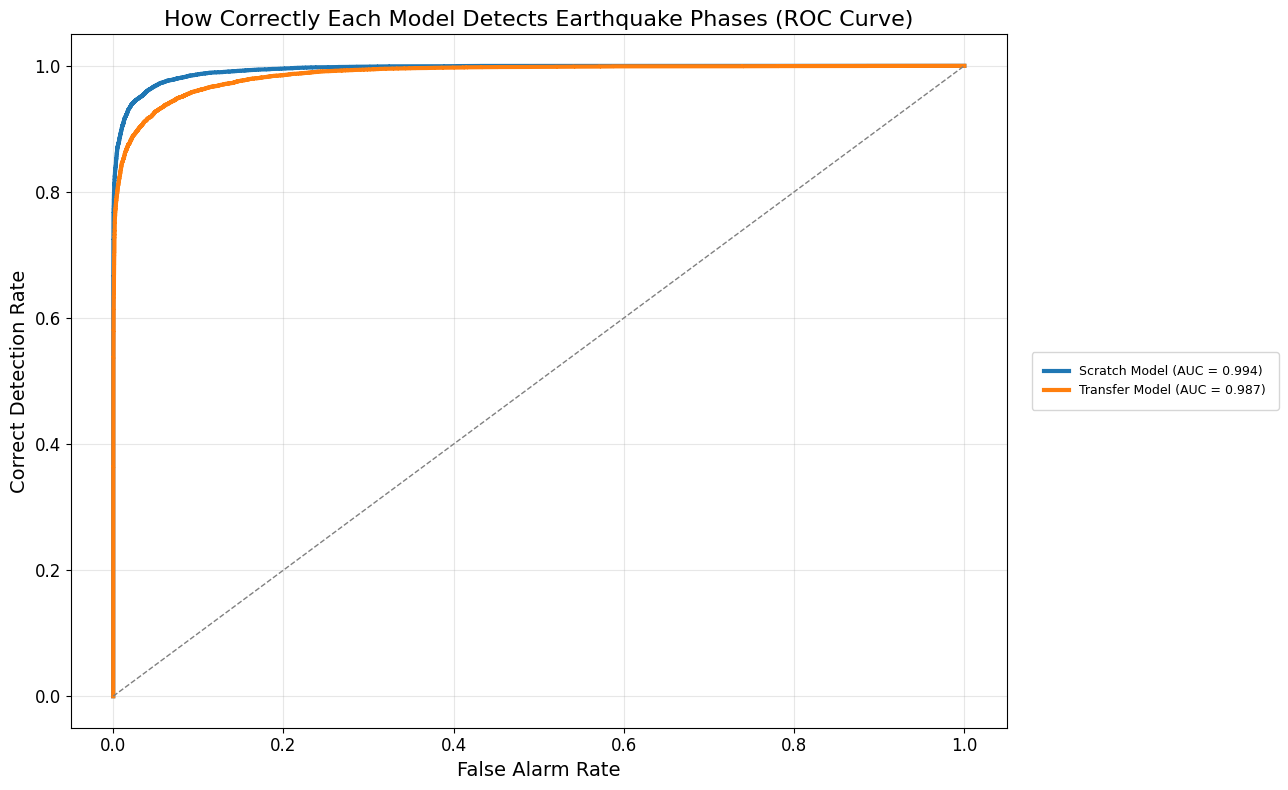

In [ ]:
def compute_roc(df):
    y_true = df["phase_label_bin"].values
    y_score = df["score_p_or_s"].values
    fpr, tpr, thr = roc_curve(y_true, y_score)
    return fpr, tpr, thr, auc(fpr, tpr)

# Compute ROC + AUC
fpr_s, tpr_s, thr_s, auc_s = compute_roc(results_scratch_model)
fpr_t, tpr_t, thr_t, auc_t = compute_roc(results_transfer_model)

plt.figure(figsize=(13, 8))

# ROC curves
plt.plot(fpr_s, tpr_s, linewidth=3, label=f"Scratch Model (AUC = {auc_s:.3f})")
plt.plot(fpr_t, tpr_t, linewidth=3, label=f"Transfer Model (AUC = {auc_t:.3f})")

# Random guess diagonal
plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)

# Clean labels for non-technical viewers
plt.title("How Correctly Each Model Detects Earthquake Phases (ROC Curve)", fontsize=16)
plt.xlabel("False Alarm Rate", fontsize=14)
plt.ylabel("Correct Detection Rate", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Put legend outside the plot (right side)
plt.legend(
    fontsize=9,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderpad=1,
)

plt.tight_layout()
plt.show()

NameError: name 'results' is not defined

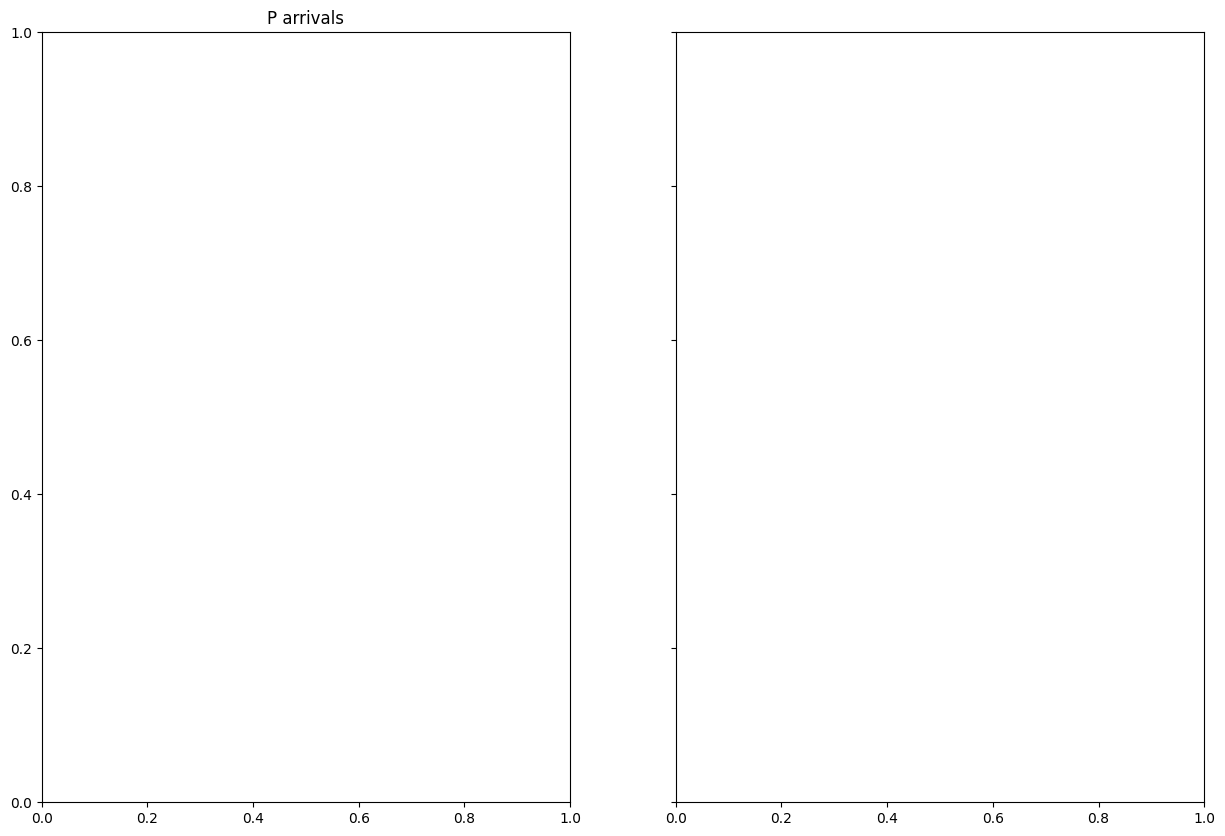

In [ ]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(1, 2, sharey=True)

for i, phase in enumerate(["P", "S"]):
    ax = axs[i]
    ax.set_title(f"{phase} arrivals")

    pred_phase = results[results["phase_label"] == phase]
    pred_col = f"{phase.lower()}_sample_pred"

    # Time difference in seconds
    diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase[
        "sampling_rate"
    ]


    # Compute stats
    mean_offset = diff.mean()
    mae = np.mean(np.abs(diff))
    rms = np.sqrt(np.mean(diff**2))

    # Plot histogram
    bins = np.linspace(-2.5, 2.5, 100)
    ax.hist(diff, bins=bins, color="skyblue", edgecolor="k")
    ax.axvline(
        mean_offset,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Mean offset = {mean_offset:.2f}s",
    )

    # Axis labels and annotation
    ax.set_xlabel("$t_{pred} - t_{true}$ [s]")
    ax.set_ylabel("Count")
    ax.text(
        0.98,
        0.95,
        f"Mean difference = {mean_offset:.2f}s\n"
        f"MAE = {mae:.2f}s\n"
        f"RMS = {rms:.2f}s\n",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=12,
        color="k",
    )

plt.tight_layout()
plt.show()

In [ ]:
test_generator = sbg.GenericGenerator(dataset.test())
test_generator.add_augmentations(model_gaussian_transfer.get_augmentations())

In [118]:
pred_transfer = model_gaussian_transfer(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()

In [ ]:
idx = np.random.randint(len(test_generator))
sample = test_generator[idx]

x = sample["X"]                # (3, 3001)
y = sample["y"] 

In [ ]:
pred_transfer = model_gaussian_transfer(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()

In [ ]:
pred_scratch = model_gaussian_scratch(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()

In [110]:
p_pred = pred_transfer[0, :]
p_pred.shape


(3, 3001)

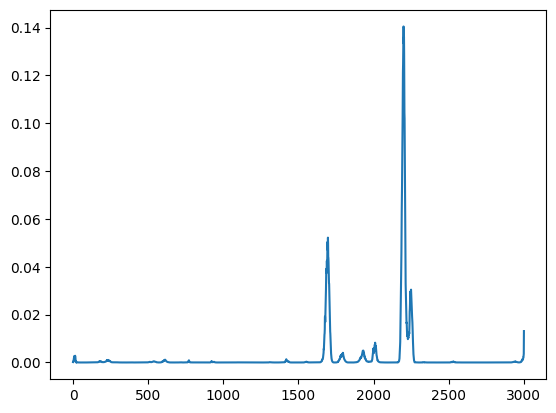

In [ ]:
plt.plot(pred_scratch[0, 1])

In [ ]:
from seisbench.generate.labeling import gaussian_pick


In [113]:
p_pred /= np.max(p_pred)

In [116]:
labels_original = gaussian_pick(onset=np.argmax(p_pred), length=p_pred.size, sigma = 100)

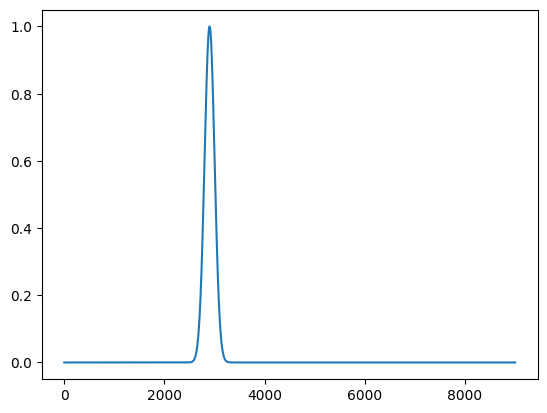

In [117]:
plt.plot(labels_original, label="Gaussian Original")

ValueError: x and y can be no greater than 2D, but have shapes (3001,) and (3001, 3, 1)

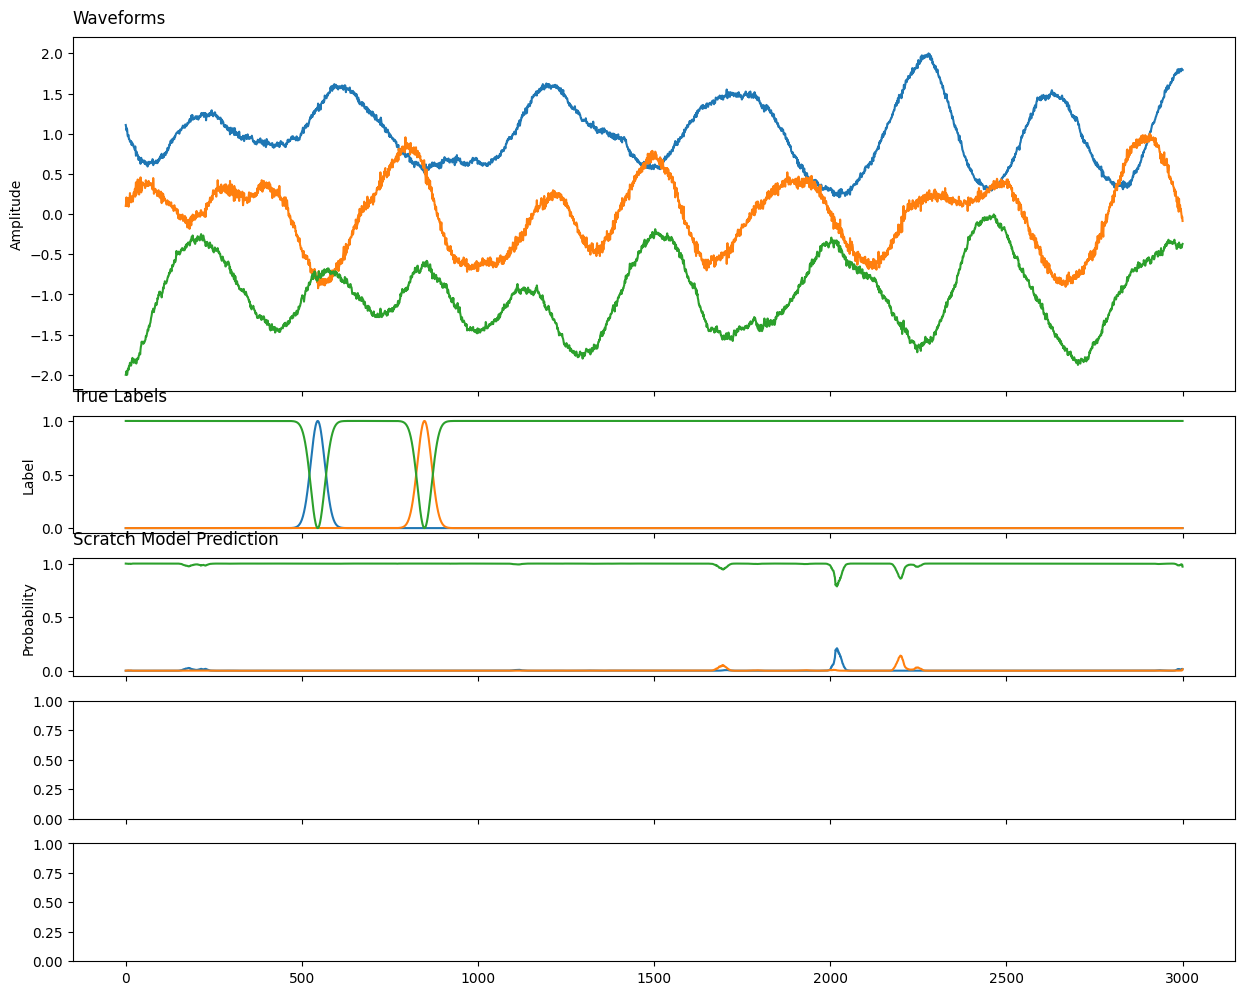

In [75]:
from seisbench.models.phasenet import PhaseNet

# Load PhaseNet
pn = PhaseNet.from_pretrained("original")

# Random sample
idx = np.random.randint(len(test_generator))
sample = test_generator[idx]

x = sample["X"]                # (3, 3001)
y = sample["y"]                # labels

# Scratch model prediction
pred_scratch = model_gaussian_scratch(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()[0]

# Original PhaseNet prediction
pred_original = pn(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()[0]

# Optional transfer model prediction
include_transfer = True
if include_transfer:
    pred_transfer = model_gaussian_transfer(torch.tensor(x.reshape(1, 3, 3001))).cpu().detach().numpy()

# ---- Build figure ----
num_plots = 4 if not include_transfer else 5
height_ratios = [3, 1, 1, 1] if not include_transfer else [3, 1, 1, 1, 1]

fig, axs = plt.subplots(
    num_plots, 1, sharex=True,
    figsize=(15, 12),
    gridspec_kw={"hspace": 0.15, "height_ratios": height_ratios}
)

# Assign axes
ax_wave = axs[0]
ax_label = axs[1]
ax_scratch = axs[2]
if include_transfer:
    ax_transfer = axs[3]
    ax_original = axs[4]
else:
    ax_original = axs[3]

# Waveforms
ax_wave.plot(x.T + np.array([1, 0, -1]))  # offset Z,N,E
ax_wave.set_ylabel("Amplitude")
ax_wave.set_title("Waveforms", loc='left', fontsize=12, pad=10)

# True labels
ax_label.plot(y.T)
ax_label.set_ylabel("Label")
ax_label.set_title("True Labels", loc='left', fontsize=12, pad=10)

# Scratch model
ax_scratch.plot(pred_scratch.T)
ax_scratch.set_ylabel("Probability")
ax_scratch.set_title("Scratch Model Prediction", loc='left', fontsize=12, pad=10)

# Transfer model (optional)
if include_transfer:
    ax_transfer.plot(pred_transfer.T)
    ax_transfer.set_ylabel("Probability")
    ax_transfer.set_title("Transfer Model Prediction", loc='left', fontsize=12, pad=10)

# Original PhaseNet
ax_original.plot(pred_original.T)
ax_original.set_ylabel("Probability")
ax_original.set_title("Original PhaseNet Prediction", loc='left', fontsize=12, pad=10)

ax_original.set_xlabel("Time steps")

plt.tight_layout()
plt.show()
